In [1]:
# set up ps environment
import ps, ps_utils
from ps_utils.env import ps
from ps.message import GlobalID
from ps_utils import env, market

import math as m
import numpy as np
import datetime as dt
import pandas as pd
import os
import subprocess
directory = os.getcwd()
from matplotlib import pyplot as plt
ps_utils.switch_to_dev()
ps_utils.logger.setLevel(ps_utils.logging.ERROR)
ps_utils.logger.setLevel(ps_utils.logging.DEBUG)


def toDate(x) :
 return dt.datetime.strptime(x, "%Y/%m/%d")


[ERROR] 2023-02-20 07:29:29,424 - You do not have xbbg installed, some functionality will not be available
[INFO] 2023-02-20 07:29:33,115 - ps client switched from prod_pvlss to dev


# Set market data and static data set

В текущем рынке нет фиксингов и кривой для RUONIA_ON пока добавим вручную. Значения не важны

In [2]:
myAlgoId = '772a59f7d99193655515726134c37d49e598cf9d' #'c0ef448ff8c7ef92164d9588ad747adc5c7faa8b'

price_dt = dt.date(2022, 8, 25) #Date for Market Data Set
mdsInitial = ps_utils.get_mds(price_dt) #Setting MDS


# add RUB_RUONIA_ON fixings and curve node for RUONIA_ON, currently we don't have it in Market data. Any fake data are fine.
mdsInitial.Fixings.RUB_RUONIA_ON  = ps.new_cm()
mdsInitial.Fixings.RUB_RUONIA_ON.TypeName = 'Fixings'
mdsInitial.Fixings.RUB_RUONIA_ON.Identifier = 'RUB_RUONIA_ON'
mdsInitial.Fixings.RUB_RUONIA_ON.Dates = [toDate('2022/03/09'),toDate('2022/03/10')]
mdsInitial.Fixings.RUB_RUONIA_ON.Values = [0.0965,0.0965]

mdsInitial.RatesCurvesBundles.RUB_RUONIA_ON  = ps.new_cm()
mdsInitial.RatesCurvesBundles.RUB_RUONIA_ON.Identifier = 'RUB_RUONIA_ON'
mdsInitial.RatesCurvesBundles.RUB_RUONIA_ON.TypeName = 'DiscountFactorCurve'
mdsInitial.RatesCurvesBundles.RUB_RUONIA_ON.RatesSchedule = {    
     'Rates':[1.0,1.0,1.0],     
     'Dates':[price_dt,	price_dt + dt.timedelta(days=10),	price_dt + dt.timedelta(days=30)]
    }
mdsInitial.RatesCurvesBundles.RUB_RUONIA_ON.RateQuoteExpression = 'Percentage'


# missed fixings in original market
mdsInitial.Fixings.USD_SOFR  = ps.new_cm()
mdsInitial.Fixings.USD_SOFR.TypeName = 'Fixings'
mdsInitial.Fixings.USD_SOFR.Identifier = 'USD_SOFR'
mdsInitial.Fixings.USD_SOFR.Dates = [toDate('2022/03/09'),toDate('2022/03/10')]
mdsInitial.Fixings.USD_SOFR.Values = [0.0965,0.0965]

mdsInitial.RatesCurvesBundles.USD_XCCY  = ps.new_cm()
mdsInitial.RatesCurvesBundles.USD_XCCY.Identifier = 'USD_XCCY'
mdsInitial.RatesCurvesBundles.USD_XCCY.TypeName = 'DiscountFactorCurve'
mdsInitial.RatesCurvesBundles.USD_XCCY.RatesSchedule = {    
     'Rates':[1.0,1.0,1.0],     
     'Dates':[price_dt,	price_dt + dt.timedelta(days=10),	price_dt + dt.timedelta(days=30)]
    }
mdsInitial.RatesCurvesBundles.USD_XCCY.RateQuoteExpression = 'Percentage'

mds=ps.put(mdsInitial)


mds_id = mds._id
sds_id = '3a488901da729b61b9b9e5313f13c5f3a5e47e1e'#'09d98b3bad8edbbdb16815ec1b7be13f76bb3a14'#edde27cc8f3f3b69c5986e565dae48dae5fa1549' #static data set with calibrating conventions
sds = ps.get(sds_id)


[DEBUG] 2023-02-20 07:29:33,324 - MarketToCanonicalFormat request: 3efe43f2218be05ad3835794f84b9ba4673ad014


In [3]:
mds_id

'8feafe6ac3506b8f894c0c5ca8e9f91147839148'

# KeyRate & RUONIA
## Set calibration request

In [4]:
    
calibrateCurves = ps.new_cm()
calibrateCurves.RequestName = 'CalibrateCurves'

calibrateCurves.DomesticForwardCurve = {
    'Identifier':'RUB_KEY_RATE',
    'Quotes' : {
        'RATE:JUL22': 8.0,
        'RATE:SEP22': 7.75,
        'RATE:OCT22': 7.75,
        'RATE:DEC22': 8.0,
        'RATE:FEB23': 8.0,
        'RATE:MAR23': 8.25,
        'RATE:APR23': 8.25,
        'RATE:JUN23': 8.5,
        'RATE:JUL23': 8.5,
        'RATE:SEP23': 8.75,
        'OISW:2Y': 8.895,
        'OISW:3Y': 9.166666667,
        'OISW:4Y': 9.348333333,
        'OISW:5Y': 9.48,
        'OISW:6Y': 9.591,
        'OISW:7Y': 9.662,
        'OISW:8Y': 9.713,
        'OISW:9Y': 9.754,
        'OISW:10Y': 9.795
        },

# convert string dates to Dates
    'MeetingSchedule' : {
        'Keys':        ['JUL22',	        'SEP22',	        'OCT22',	         'DEC22',	          'FEB23',	'MAR23',	'APR23',	       'JUN23',	            'JUL23',	        'SEP23'],
        'StartDates' : [dt.date(2022,7,25),	dt.date(2022,9,19),  dt.date(2022,10,31), dt.date(2022,12,19), dt.date(2023,2,13),	dt.date(2023,3,20),	dt.date(2023,5,2),	dt.date(2023,6,12),	dt.date(2023,7,24),	dt.date(2023,9,18)],
        'EndDates' :   [dt.date(2022,9,19),	dt.date(2022,10,31), dt.date(2022,12,19), dt.date(2023,2,13),  dt.date(2023,3,20),	dt.date(2023,5,2),	dt.date(2023,6,12),	dt.date(2023,7,24),	dt.date(2023,9,18),	dt.date(2023,10,30)]
        }
}


calibrateCurves.DiscountFactorCurve = {
    'Identifier' : 'RUB_RUONIA_ON',
    'KeyRateSpreads' : {
        'OIDG:1D': 1.0,
        'OISW:1W': 1.0,
        'OISW:2W': 1.0,
        'OISW:1M': 1.0,
        'OISW:2M': 1.0,
        'OISW:3M': 1.0,
        'OISW:6M': 1.0,
        'OISW:9M': 1.0,
        'OISW:12M': 1.0,
        'OISW:2Y': 1.0,
        'OISW:3Y': 1.0,
        'OISW:4Y': 1.0,
        'OISW:5Y': 1.0,
        'OISW:6Y': 1.0,
        'OISW:7Y': 1.0,
        'OISW:8Y': 1.0,
        'OISW:9Y': 1.0,
        'OISW:10Y': 1.0}
}
calibrateCurves.RateQuoteExpression = 'Percentage'
calibrateCurves.CalibrationUseGlobalSolver = False
calibrateCurves.MarketDataSet = mds_id
calibrateCurves.StaticDataSet = sds_id

In [5]:
result=ps_utils.compute(calibrateCurves,algo_id=myAlgoId)

[INFO] 2023-02-20 07:29:33,621 - Compute:2d537646366a383795138eb91cc3b0a38295b1a7->c5b0a5f6eace8cf4852d3bfbce8b74ce34ff6d93


## Get instruments info

In [6]:
keyRateInstruments=ps.get(result['Curve1']['Instruments']) # KeyRate instruments
keyRateSwaps=ps.get(result['Curve1']['SwapInstruments']) # KeyRate swaps used for spread calculation
ruoniaInstruments=ps.get(result['Curve1']['SwapInstruments']) # RUONIA instruments

In [7]:
keyRateInstruments.Instruments['Tickers']

['RATE:JUL22',
 'RATE:SEP22',
 'RATE:OCT22',
 'RATE:DEC22',
 'RATE:FEB23',
 'RATE:MAR23',
 'RATE:APR23',
 'RATE:JUN23',
 'RATE:JUL23',
 'RATE:SEP23',
 'OISW:2Y',
 'OISW:3Y',
 'OISW:4Y',
 'OISW:5Y',
 'OISW:6Y',
 'OISW:7Y',
 'OISW:8Y',
 'OISW:9Y',
 'OISW:10Y']

## Get specific instrument argumrnts

In [8]:
print(keyRateInstruments.Instruments['Tickers'][1])
ps.get(keyRateInstruments.Instruments['Arguments'][1])

RATE:SEP22


MessageMap([('Leg1IndexIdentifier', 'RUB_KEY_RATE'),
            ('Leg2FixedRate', 0.07750000059604645),
            ('Leg1FloatingRateSpread', 0.0),
            ('TypeName', 'InterestRatesSwapProduct'),
            ('Leg1Currency', 'RUB'),
            ('Leg1DayCountConvention', 'ActAct'),
            ('Leg2DayCountConvention', 'ActAct'),
            ('Leg2Currency', 'RUB'),
            ('Leg1IsReceiver', True),
            ('Leg1Notionals', [1000000.0]),
            ('Leg1PeriodStartDates',
             [datetime.datetime(2022, 9, 19, 0, 0, tzinfo=datetime.timezone.utc)]),
            ('Leg1PeriodEndDates',
             [datetime.datetime(2022, 10, 31, 0, 0, tzinfo=datetime.timezone.utc)]),
            ('Leg1PaymentDates',
             [datetime.datetime(2022, 10, 31, 0, 0, tzinfo=datetime.timezone.utc)]),
            ('Leg2Notionals', [1000000.0]),
            ('Leg2PeriodStartDates',
             [datetime.datetime(2022, 9, 19, 0, 0, tzinfo=datetime.timezone.utc)]),
            ('Le

## View calibrated curves

In [9]:

mds_id_withRUONIA = result['MarketId']
newMarket=ps.get(result['MarketId'])

KeyRateResults = pd.DataFrame({'Dates':result['Curve1']['Dates'],'Rates':result['Curve1']['Rates'],'Discnt':result['Curve1']['DiscountFactors'],'Errors':result['Curve1']['Errors']})
RUONIAResults = pd.DataFrame({'Dates':result['Curve2']['Dates'],'Rates':result['Curve2']['Rates'],'Discnt':result['Curve2']['DiscountFactors'],'Errors':result['Curve2']['Errors']})

pd.options.display.float_format = '{:,.10f}'.format



In [10]:
KeyRateResults['Rates']
KeyRateResults['Discnt']


0    0.9944549814
1    0.9856277810
2    0.9754284942
3    0.9635319708
4    0.9561703556
5    0.9467103761
6    0.9379796809
7    0.9290621448
8    0.9170274022
9    0.9078426784
10   0.8405291471
11   0.7647854324
12   0.6942734923
13   0.6294399223
14   0.5696497029
15   0.5157087759
16   0.4672662805
17   0.4232833222
18   0.3828382896
Name: Discnt, dtype: float64

In [11]:
KeyRateResults.style.format({"Dates": lambda t: t.strftime("%d/%m/%Y")})

,Dates,Discnt,Errors,Rates
0,19/09/2022,0.994455,-1.27329e-10,0.0799828
1,31/10/2022,0.985628,-1.30967e-10,0.0784256
2,19/12/2022,0.975428,-0.00033086,0.078029
3,13/02/2023,0.963532,-1.70985e-10,0.0786634
4,20/03/2023,0.95617,3.61979e-10,0.0788861
5,03/05/2023,0.94671,9.05857e-10,0.0795153
6,13/06/2023,0.93798,7.93079e-10,0.0799311
7,24/07/2023,0.929062,5.45697e-12,0.0805596
8,18/09/2023,0.917027,6.58474e-10,0.0811956
9,30/10/2023,0.907843,1.16415e-10,0.0818075


In [12]:
RUONIAResults.style.format({"Dates": lambda t: t.strftime("%d/%m/%Y")})

,Dates,Discnt,Errors,Rates
0,26/08/2022,0.99972,-6.77149e-14,0.0699849
1,01/09/2022,0.998572,1.75727e-15,0.0699542
2,08/09/2022,0.997235,7.55819e-15,0.0699078
3,26/09/2022,0.99386,-1.87871e-15,0.069253
4,25/10/2022,0.988591,-2.61423e-15,0.0681489
5,25/11/2022,0.983019,-6.05592e-15,0.0676119
6,27/02/2023,0.966054,-1.49013e-15,0.067605
7,25/05/2023,0.95032,-2.10075e-15,0.0680148
8,25/08/2023,0.933655,1.56299e-15,0.0685625
9,26/08/2024,0.858195,-4.55382e-14,0.0762052


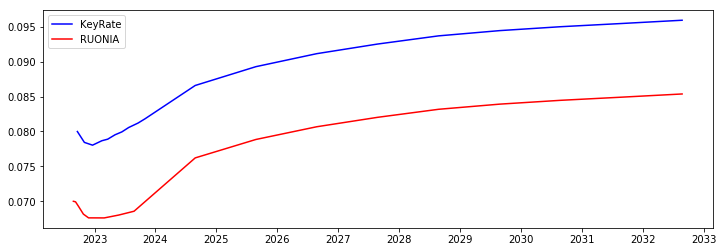

In [13]:
fig = plt.figure(figsize=(12, 4));
plt.plot(KeyRateResults.Dates, KeyRateResults.Rates, c ='b', label = 'KeyRate');
plt.plot(RUONIAResults.Dates, RUONIAResults.Rates, c ='r', label = 'RUONIA');
plt.legend()
plt.show()


# USD_XCCY by Spreads

In [14]:
#mdsUSDXCCY= ps.get(resultSOFR.MarketId)
mdsUSDXCCY= ps.get(mds_id_withRUONIA)
mdsUSDXCCY.RatesCurvesBundles.USD_XCCY_Spread  = ps.new_cm()
mdsUSDXCCY.RatesCurvesBundles.USD_XCCY_Spread.Identifier = 'USD_XCCY_Spread'
mdsUSDXCCY.RatesCurvesBundles.USD_XCCY_Spread.TypeName = 'DiscountFactorCurve'
mdsUSDXCCY.RatesCurvesBundles.USD_XCCY_Spread.RatesSchedule = {    
     'Rates':[1.0,1.0,1.0],     
     'Dates':[price_dt,	price_dt + dt.timedelta(days=10),	price_dt + dt.timedelta(days=30)]
    }
mdsUSDXCCY.RatesCurvesBundles.USD_XCCY_Spread.RateQuoteExpression = 'Percentage'
mdsUSDXCCY.RatesCurvesBundles.USD_XCCY_Spread.Quotes  = {
    'Tickers':['FxFwd:O/N', 'FxFwd:1D', 'FxFwd:1W', 'FxFwd:2W', 'FxFwd:1M', 'FxFwd:2M', 'FxFwd:3M', 'FxFwd:6M', 'FxFwd:9M',
                "OISWF:1Y",	"OISWF:2Y",	"OISWF:3Y",	"OISWF:4Y",	"OISWF:5Y",	"OISWF:6Y",	"OISWF:7Y",	"OISWF:8Y",	"OISWF:9Y",	"OISWF:10Y", "OISWF:12Y", "OISWF:15Y"],    
    'Values':[150.999999993896,	390.01721010032,	909.041095923558,	1818.08219180946,	3974.92288741207,	7508.11011797928,	11227.8567914607,	21692.6882474997,	31566.5488111604,
              1.444113275,	1.995,	1.216666667,	1.398333333,	1.48,	1.591,	1.662,	1.713,	1.754,	1.795,	1.836,	1.877]
    }


mdsUSDXCCY.Fixings.USD_XCCY_Spread  = ps.new_cm()
mdsUSDXCCY.Fixings.USD_XCCY_Spread.TypeName = 'Fixings'
mdsUSDXCCY.Fixings.USD_XCCY_Spread.Identifier = 'USD_XCCY_Spread'
mdsUSDXCCY.Fixings.USD_XCCY_Spread.Dates = [toDate('2022/03/09'),toDate('2022/03/10')]
mdsUSDXCCY.Fixings.USD_XCCY_Spread.Values = [0.0965,0.0965]


newMDS=ps.put(mdsUSDXCCY)
newMDS._id

'8978674fa8ec07ee59e97fb37324fa07323b0452'

In [15]:
calibrateUSDXCCY = ps.new_cm()
calibrateUSDXCCY.RequestName = 'CalibrateCurveUsingMarketDataSet'

calibrateUSDXCCY.MarketDataSet = newMDS._id
calibrateUSDXCCY.StaticDataSet = sds_id
calibrateUSDXCCY.Identifier = 'USD_XCCY_Spread'
calibrateUSDXCCY.CalibrationUseGlobalSolver = False

resultUSDXCCY=ps_utils.compute(calibrateUSDXCCY,algo_id=myAlgoId)

[INFO] 2023-02-20 07:29:34,530 - Compute:fef66a0b2ebe85fa435e3bfa21374bdbfb0ebc80->d306987669d39f63b9894a4554d49831f98232e0


In [16]:
ps_utils.compute(calibrateUSDXCCY,algo_id=myAlgoId)

[INFO] 2023-02-20 07:29:34,600 - Compute:fef66a0b2ebe85fa435e3bfa21374bdbfb0ebc80->d306987669d39f63b9894a4554d49831f98232e0


Dict([('MarketId', '6a86a8c8be1295c11156fd77aa40d9f17468be75'),
      ('Dates',
       [datetime.datetime(2022, 8, 26, 0, 0, 1, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 8, 29, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 2, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 9, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 26, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 10, 26, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 11, 28, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2023, 2, 27, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2023, 5, 26, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2023, 8, 28, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2024, 8, 27, 0, 0, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 8, 26, 0, 0, tzinfo=datetime.timezone.utc),
     